In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

class BobNet(nn.Module):
    """
        The BobNet model that will be used to swing.
    """
 
    def __init__(self, input_size: int, output_size: int, hidden_dim: int,
                 n_layers: int, seq_length: int, bidirectional: bool=True, drop_prob: float=0.1):
        """
            Initialize the model by setting up the layers.
        """
        super(BobNet, self).__init__()
 
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.seq_length = seq_length
        self.input_size = input_size
        self.num_directions = 2 if self.bidirectional else 1
        
        #LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=False,
                            bidirectional=bidirectional)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # linear and sigmoid layers
        if bidirectional:
          self.fc = nn.Linear(hidden_dim*2, output_size)
        else:
          self.fc = nn.Linear(hidden_dim, output_size)
        
        
 
    def forward(self, x, hidden):
        """
            Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        # assert x.shape==(batch_size,self.seq_length, self.input_size)
        # If not batch_first, switch seq_length and batch_size position.
        x.transpose_(1,0)
        lstm_out, hidden = self.lstm(x, hidden)
        h_n, c_n = hidden
        # assert lstm_out.shape==(self.seq_length, batch_size, self.hidden_dim )
        # assert h_n.shape==c_n.shape==(self.n_layers*self.num_directions, batch_size, self.hidden_dim)
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        # use last seq as out
        out = out[-1]
        out = self.fc(out)

        # reshape to be batch_size first
        out = out.view(batch_size, -1)
        return out, hidden
    
    
    def init_hidden(self, batch_size: int):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers*self.num_directions, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers*self.num_directions, batch_size, self.hidden_dim).zero_()
                     )
        return hidden


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import r2_score
# from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_dim: int,
                n_layers: int, seq_length: int, bidirectional: bool=True, drop_prob: float=0.1):
        super(BiLSTM_Attention, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.seq_length = seq_length
        self.input_size = input_size
        self.num_directions = 2 if self.bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=False, bidirectional=bidirectional)
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        # self.out = nn.Linear(n_hidden * 2, num_classes)
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # linear and sigmoid layers
        if bidirectional:
          self.fc = nn.Linear(hidden_dim*2, output_size)
        else:
          self.fc = nn.Linear(hidden_dim, output_size)


    def attention_net(self,lstm_output, final_state):
        # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
        # final_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        batch_size = len(lstm_output)
        # hidden = final_state.view(batch_size,-1,1)
        if self.bidirectional:
            hidden = torch.cat((final_state[0],final_state[1]),dim=1).unsqueeze(2)
        else:
            hidden = final_state[0].unsqueeze(2)
        # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=1)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        # attn_weights : [batch_size,n_step]
        soft_attn_weights = F.softmax(attn_weights,1)

        # context: [batch_size, n_hidden * num_directions(=2)]
        context = torch.bmm(lstm_output.transpose(1,2),soft_attn_weights.unsqueeze(2)).squeeze(2)

        return context, soft_attn_weights

    def forward(self,X, hidden):
        '''
        :param X: [batch_size, seq_len]
        :return:
        '''
        input = X # input : [batch_size, seq_len, embedding_dim]
        input = input.transpose(0, 1) # input : [seq_len, batch_size, embedding_dim]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        # output : [seq_len, batch_size, n_hidden * num_directions(=2)]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, hidden)
        output = output.transpose(0, 1) #output : [batch_size, seq_len, n_hidden * num_directions(=2)]

        attn_output, attention = self.attention_net(output,final_hidden_state)
        return self.fc(attn_output),attention # attn_output : [batch_size, num_classes], attention : [batch_size, n_step]

    def init_hidden(self, batch_size: int):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers*self.num_directions, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers*self.num_directions, batch_size, self.hidden_dim).zero_()
                      )
        return hidden

In [3]:
# Init model
batch_size=50
hidden_dim=5
input_size=5
seq_length=5
n_layers=1
output_size=1

In [5]:
# dian
data = pd.read_csv('84数据/51formant.csv')
dian = []
dian_y = []
for i in range(len(data)):
    if data.iloc[i, 1] is np.nan:
        list = []
        for j in range(5):
            list.append([0, 0, 0, 0, 0])
        dian.append(list)
        dian_y.append([float(data.iloc[i, 0])])
    else:
        list = []
        for t in range(5-len(data.iloc[i, 1].split(','))):
            list.append([0, 0, 0, 0, 0])
        for j in range(len(data.iloc[i, 1].split(','))):
            list.append([float(data.iloc[i, 1].split(',')[j]), float(data.iloc[i, 2].split(';')[j]),float(data.iloc[i, 3].split(';')[j]),float(data.iloc[i, 4].split(';')[j]),float(data.iloc[i, 5].split(';')[j])])
        dian.append(list)
        dian_y.append([float(data.iloc[i, 0])])
dian =np.array(dian).astype(np.float32)
dian_y = np.array(dian_y).astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dian, dian_y, test_size=0.3, random_state=100)
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
dataset_x = Data.TensorDataset(X_train, y_train)
dataset_y = Data.TensorDataset(X_val, y_val)
train_loader = Data.DataLoader(dataset_x, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset_y, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
# dian, 带宽
data = pd.read_csv('84数据/51formant.csv')
dian = []
dian_y = []
for i in range(len(data)):
    if data.iloc[i, 1] is np.nan:
        list = []
        for j in range(5):
            list.append([0, 0, 0, 0, 0])
        dian.append(list)
        dian_y.append([float(data.iloc[i, 0])])
    else:
        list = []
        for t in range(5-len(data.iloc[i, 1].split(','))):
            list.append([0, 0, 0, 0, 0])
        for j in range(len(data.iloc[i, 1].split(','))):
            list.append([float(data.iloc[i, 1].split(',')[j]), float(data.iloc[i, 2].split(';')[j]),float(data.iloc[i, 3].split(';')[j]),float(data.iloc[i, 4].split(';')[j]),float(data.iloc[i, 5].split(';')[j])])
        dian.append(list)
        dian_y.append([float(data.iloc[i, 0])])
dian =np.array(dian).astype(np.float32)
dian_y = np.array(dian_y).astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dian, dian_y, test_size=0.3, random_state=100)
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
dataset_x = Data.TensorDataset(X_train, y_train)
dataset_y = Data.TensorDataset(X_val, y_val)
train_loader = Data.DataLoader(dataset_x, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset_y, batch_size=batch_size, shuffle=True, num_workers=0)

In [23]:
# ci
data = pd.read_csv('84数据/51formant.csv')
ci = []
ci_y = []
for i in range(len(data)):
    if data.iloc[i, 6] is np.nan:
        list = []
        for j in range(2):
            list.append([0, 0, 0, 0, 0])
        ci.append(list)
        ci_y.append([float(data.iloc[i, 0])])
    else:
        list = []
        for t in range(2-len(data.iloc[i, 6].split(','))):
            list.append([0, 0, 0, 0, 0])
        for j in range(len(data.iloc[i, 6].split(','))):
            list.append([float(data.iloc[i, 6].split(',')[j]), float(data.iloc[i, 7].split(';')[j]),float(data.iloc[i, 8].split(';')[j]),float(data.iloc[i, 9].split(';')[j]),float(data.iloc[i, 10].split(';')[j])])
        ci.append(list)
        ci_y.append([float(data.iloc[i, 0])])
ci =np.array(ci).astype(np.float32)
ci_y = np.array(ci_y).astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(ci, ci_y, test_size=0.3, random_state=2022)
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
dataset_x = Data.TensorDataset(X_train, y_train)
dataset_y = Data.TensorDataset(X_val, y_val)
train_loader = Data.DataLoader(dataset_x, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset_y, batch_size=batch_size, shuffle=True, num_workers=0)

In [17]:
# dian,ci
data = pd.read_csv('84数据/51formant.csv')
dici = []
dici_y = []
for i in range(len(data)):
    if data.iloc[i, 1] is np.nan:
        list = []
        for j in range(5):
            list.append([0, 0, 0, 0, 0])
        if data.iloc[i, 6] is np.nan:
            for j in range(2):
                list.append([0, 0, 0, 0, 0])
            dici.append(list)
            dici_y.append([float(data.iloc[i, 0])])
        else:
            for t in range(2-len(data.iloc[i, 6].split(','))):
                list.append([0, 0, 0, 0, 0])
            for j in range(len(data.iloc[i, 6].split(','))):
                list.append([float(data.iloc[i, 6].split(',')[j]), float(data.iloc[i, 7].split(';')[j]),float(data.iloc[i, 8].split(';')[j]),float(data.iloc[i, 9].split(';')[j]),float(data.iloc[i, 10].split(';')[j])])
            dici.append(list)
            dici_y.append([float(data.iloc[i, 0])])
    else:
        list = []
        for t in range(5-len(data.iloc[i, 1].split(','))):
            list.append([0, 0, 0, 0, 0])
        for j in range(len(data.iloc[i, 1].split(','))):
            list.append([float(data.iloc[i, 1].split(',')[j]), float(data.iloc[i, 2].split(';')[j]),float(data.iloc[i, 3].split(';')[j]),float(data.iloc[i, 4].split(';')[j]),float(data.iloc[i, 5].split(';')[j])])
        if data.iloc[i, 6] is np.nan:
            for j in range(2):
                list.append([0, 0, 0, 0, 0])
            dici.append(list)
            dici_y.append([float(data.iloc[i, 0])])
        else:
            for t in range(2-len(data.iloc[i, 6].split(','))):
                list.append([0, 0, 0, 0, 0])
            for j in range(len(data.iloc[i, 6].split(','))):
                list.append([float(data.iloc[i, 6].split(',')[j]), float(data.iloc[i, 7].split(';')[j]),float(data.iloc[i, 8].split(';')[j]),float(data.iloc[i, 9].split(';')[j]),float(data.iloc[i, 10].split(';')[j])])
            dici.append(list)
            dici_y.append([float(data.iloc[i, 0])])
dici =np.array(dici).astype(np.float32)
dici_y = np.array(dici_y).astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dici, dici_y, test_size=0.3, random_state=2022)
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
dataset_x = Data.TensorDataset(X_train, y_train)
dataset_y = Data.TensorDataset(X_val, y_val)
train_loader = Data.DataLoader(dataset_x, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset_y, batch_size=batch_size, shuffle=True, num_workers=0)

In [24]:
bob = BobNet(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim,
                n_layers=n_layers, seq_length=seq_length, bidirectional=True, drop_prob=0)

# Set optimizer and loss function
optimizer = torch.optim.Adam(bob.parameters(), lr=0.005)
criterion = nn.SmoothL1Loss() # SmoothL1Loss

In [5]:
bob = BiLSTM_Attention(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim,
                n_layers=n_layers, seq_length=seq_length, bidirectional=True, drop_prob=0)
optimizer = torch.optim.Adam(bob.parameters(), lr=0.005)
criterion = nn.SmoothL1Loss() # SmoothL1Loss

In [25]:
train_loss = []
train_r2 = []
test_loss = []
test_r2 = []
best_score = -1
flag = 0

In [27]:
for epoch in range(10000):
    for i, (x, y) in enumerate(train_loader):
        # If use cuda please get x and y to device.
        # device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
        # x = x.to(device)
        # y = y.to(device)
        bob.train()
        h = bob.init_hidden(batch_size)
        pre_y, _ = bob(x, h)

        loss = criterion(pre_y, y)
        # Backpropagation
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('train loss: ', loss.data.item())
        score = r2_score(y, pre_y.detach().numpy())
        print('train r2: ', score)
        train_loss.append(loss.data.item())
        train_r2.append(score)
    bob.eval()
    h_test = bob.init_hidden(X_val.shape[0])
    pre_y_test, _ = bob(X_val.clone(), h_test)
    pre_y_test = pre_y_test.detach()
    loss_test = criterion(pre_y_test, y_val)
    score_test = r2_score(y_val, pre_y_test.numpy())
    test_loss.append(loss_test.data.item())
    test_r2.append(score_test)
    print('test loss: ', loss_test.data.item())
    print('test r2: ', score_test)
    bob.train()
    # if score_test > best_score:
    #     best_score = score_test
    #     flag = 0
    # else:
    #     flag += 1
    # if flag == 100:
    #     break


train loss:  4.883158206939697
train r2:  -0.006070438059383676
test loss:  6.79273796081543
test r2:  -0.25129557912214917
train loss:  4.881232738494873
train r2:  -0.0052176059844177836
test loss:  6.793751239776611
test r2:  -0.25143738986694375
train loss:  4.879312992095947
train r2:  -0.004367018238182752
test loss:  6.794764518737793
test r2:  -0.25157880772056096
train loss:  4.877399444580078
train r2:  -0.003518860847038452
test loss:  6.795774459838867
test r2:  -0.25171945399796525
train loss:  4.875491142272949
train r2:  -0.002672870103889613
test loss:  6.796780586242676
test r2:  -0.2518587483815291
train loss:  4.873586177825928
train r2:  -0.0018290444587456545
test loss:  6.797781467437744
test r2:  -0.25199623742168353
train loss:  4.871681213378906
train r2:  -0.0009871240855987562
test loss:  6.798774719238281
test r2:  -0.25213143078122724
train loss:  4.869773864746094
train r2:  -0.0001471388897529291
test loss:  6.799759387969971
test r2:  -0.252263837508506


In [9]:
best_score = format(best_score, ".2f")

In [10]:
import matplotlib.pyplot as plt

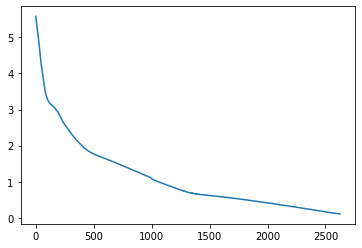

In [11]:
plt.figure()
plt.plot(train_loss)
plt.show()

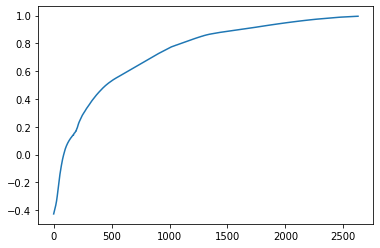

In [12]:
plt.figure()
plt.plot(train_r2)
plt.show()

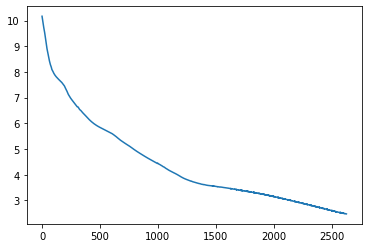

In [13]:
plt.figure()
plt.plot(test_loss)
plt.show()

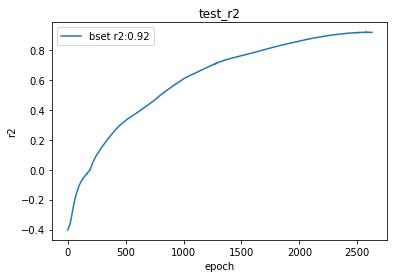

In [14]:
plt.figure()
plt.title("test_r2")
plt.xlabel("epoch")
plt.ylabel("r2")
plt.plot(test_r2, label=f"bset r2:{best_score}")
plt.legend()
plt.savefig('t2')


In [15]:
test_r2.sort()
test_r2[-1]

0.919204254243851